# Analytics Vidhya Data Science Competition

# Problem

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.
 
Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

# Data

<img src='big mart data descrip.JPG'>

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import skew, norm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
train = pd.read_csv('big mart train.csv')
test = pd.read_csv('big mart test.csv')

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
train['Item_Outlet_Sales'].mean()

2181.2889135750365

In [5]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


## Filling in Missing Data

In [6]:
# checking any aberrances in datatypes and null values
# Some values in weight and outlet size columns are missing

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [7]:
# Same products will have same weights. Using this fact, we can fill in null values in the Item_Weight column.

train['Item_Weight']=\
train.groupby(['Item_Identifier'])['Item_Weight'].ffill().bfill()

In [8]:
# Having the same outlet idenitfiers means the outlets have same outlet size. 
# Using this fact, we can fill in null values in the Outlet_Size column.

train['Outlet_Size'] = train.groupby('Outlet_Identifier')['Outlet_Size'].ffill().bfill()

In [9]:
train.info()
# We don't have any null values left :D

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


## Fixing Weird Labels

Categorical Features

Ordinal
- Item_Fat_Content : Regular, Low ...
- Outlet_Size: Medium , High...

Nominal
- Item_Type
- Outlet_Location_Type
- Outlet_type

In [10]:
# Since item_identifier is not a feature, we'll use that column as our index
train.set_index(['Item_Identifier', 'Outlet_Identifier'], inplace=True)

In [11]:
# Have inconsistent labels. Need to make it uniform.

train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [12]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.replace('LF', 'Low Fat')
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.replace('reg', 'Regular')
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.replace('low fat', 'Low Fat')

In [13]:
# 3 categories. No inconsistent labels. But unclear naming found. Let's change the label "high" to Big.
train['Outlet_Size'].value_counts()

Medium    3940
Small     3290
High      1293
Name: Outlet_Size, dtype: int64

In [14]:
train['Outlet_Size'] = train['Outlet_Size'].str.replace('High', 'Big')

In [15]:
# No weird labels
train['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [16]:
# No weird labels
train['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [17]:
# No weird labels
train['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [18]:
# No weird labels
train['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

## Exploration through Visualization

### Visualization of Numerical Features

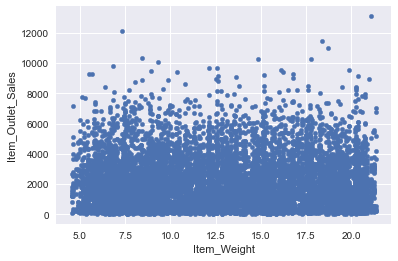

In [19]:
train.plot.scatter('Item_Weight', 'Item_Outlet_Sales')

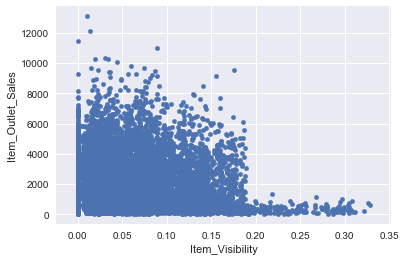

In [20]:
train.plot.scatter('Item_Visibility', 'Item_Outlet_Sales')

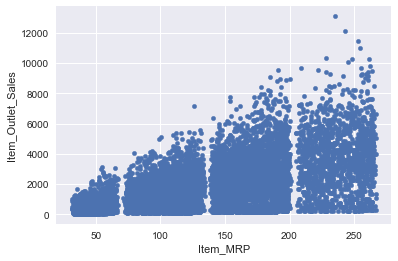

In [21]:
train.plot.scatter('Item_MRP', 'Item_Outlet_Sales')

### Visualization of Categorical Features

In [22]:
# To estimate the figsize when drawing graphs
(train['Item_Outlet_Sales'].max() - train['Item_Outlet_Sales'].min())/1000

13.0536748

In [23]:
print(train.select_dtypes(include=['object']).columns.values)

['Item_Fat_Content' 'Item_Type' 'Outlet_Size' 'Outlet_Location_Type'
 'Outlet_Type']


#### Item_Fat_Content

In [24]:
train['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

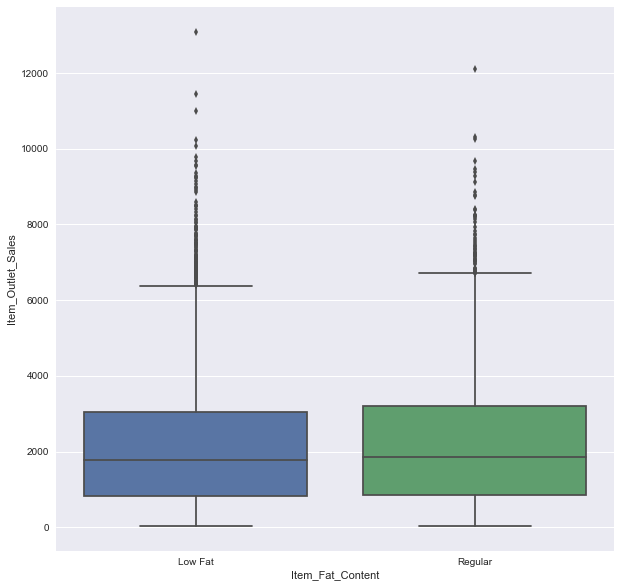

In [25]:
plt.figure(figsize = (10, 10))
sns.boxplot(x = 'Item_Fat_Content', y = 'Item_Outlet_Sales',  data = train)
#plt.xticks(rotation=45)

#### Item_Type

In [26]:
len(train['Item_Type'].value_counts().index)

16

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

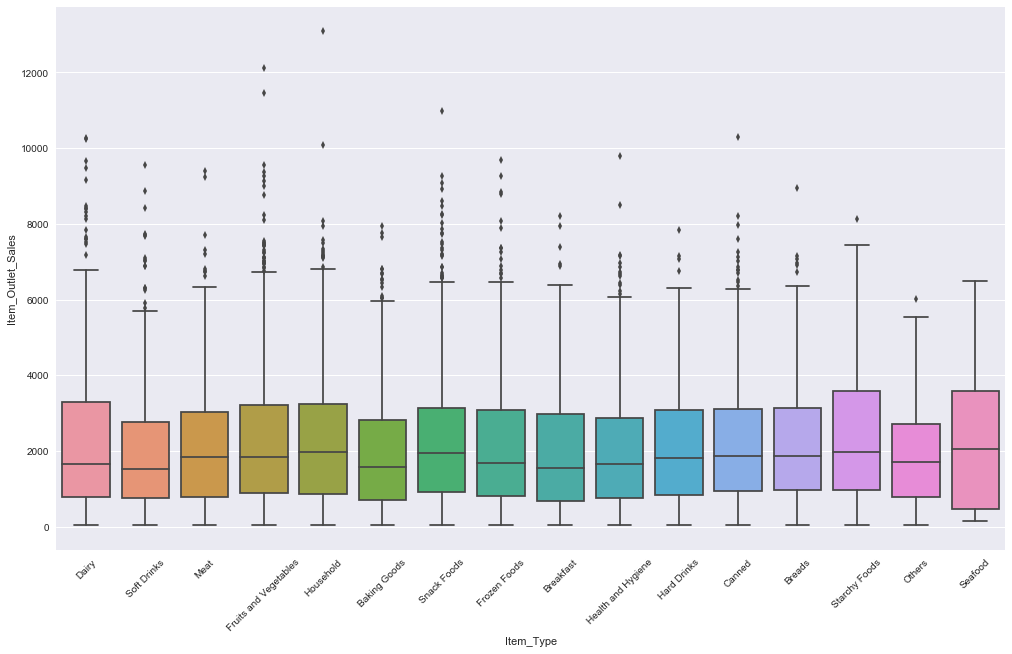

In [27]:
plt.figure(figsize = (17, 10))
sns.boxplot(x = 'Item_Type', y = 'Item_Outlet_Sales',  data = train)
plt.xticks(rotation=45)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

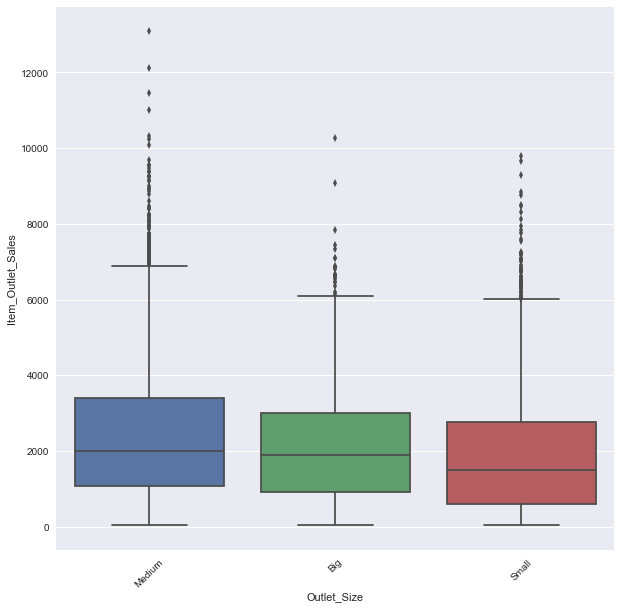

In [28]:
plt.figure(figsize = (10, 10))
sns.boxplot(x = 'Outlet_Size', y = 'Item_Outlet_Sales',  data = train)
plt.xticks(rotation=45)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

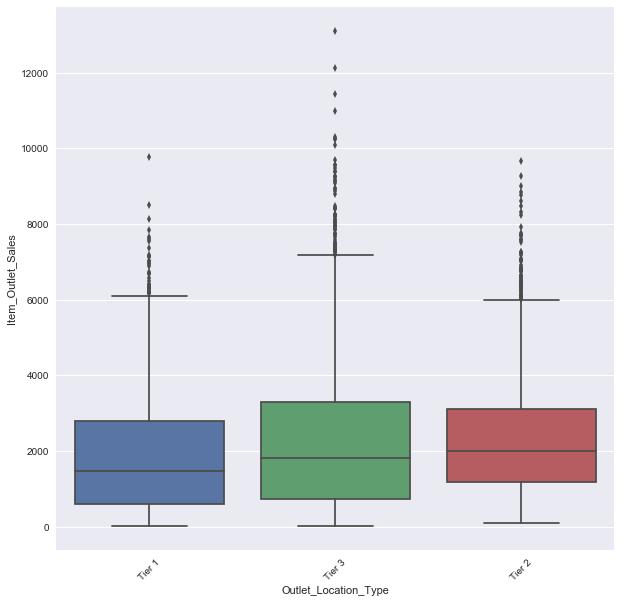

In [29]:
plt.figure(figsize = (10, 10))
sns.boxplot(x = 'Outlet_Location_Type', y = 'Item_Outlet_Sales',  data = train)
plt.xticks(rotation=45)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

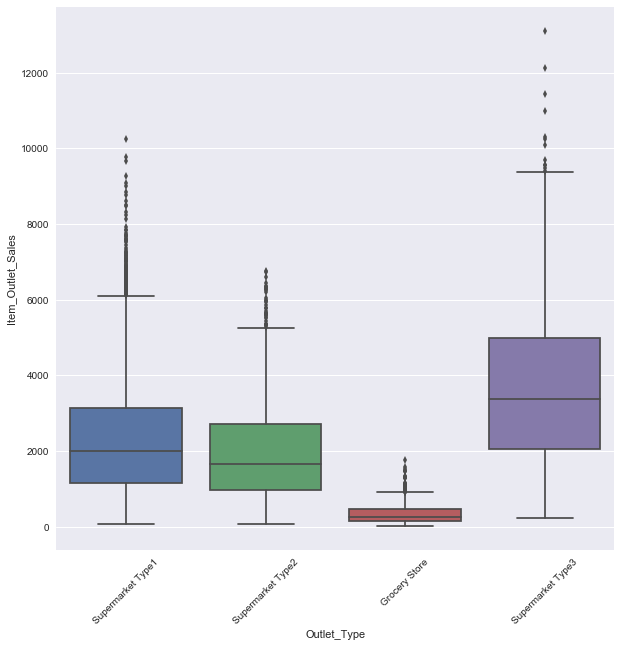

In [30]:
plt.figure(figsize = (10, 10))
sns.boxplot(x = 'Outlet_Type', y = 'Item_Outlet_Sales',  data = train)
plt.xticks(rotation=45)

### Correlation Maxtrix

In [31]:
corrmat = train.corr()

corrmat

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.008834,0.024257,-0.017002,0.010643
Item_Visibility,-0.008834,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024257,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.017002,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.010643,-0.128625,0.567574,-0.049135,1.000000


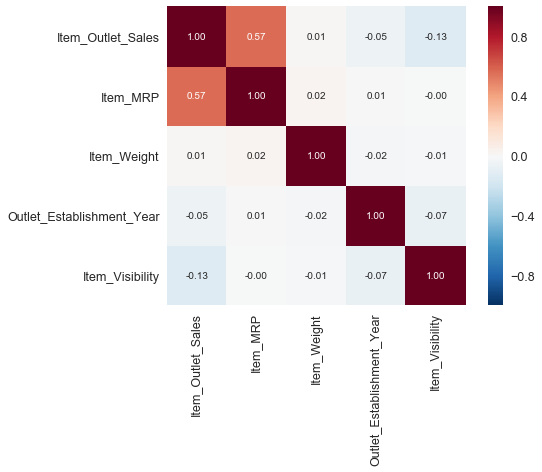

In [32]:
k = 5 # number of variables for heatmap

cols = corrmat.nlargest(k, 'Item_Outlet_Sales')['Item_Outlet_Sales'].index
cm = np.corrcoef(train[cols].values.T)

sns.set(font_scale=1.25)

sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

## Removing Outliers

##### From the exploration above, we can assume that sales that are over approximately 11000 can be considered as outliers and should be removed from the dataset

In [33]:
train = train[train.Item_Outlet_Sales <= 10000]

## Creating New Features

In [34]:
# Only item_MRP has strong correlation with Item_Outlet_Sales, so only using item_MRP to create new features

train['Item_MRP-2']= train['Item_MRP'] **2
train['Item_MRP-3']= train['Item_MRP'] **3
train['Item_MRP-sq'] = np.sqrt(train['Item_MRP'])

## Encoding Oridinal Features (Categorical)

In [35]:
train.Item_Fat_Content.value_counts()

Low Fat    5512
Regular    3003
Name: Item_Fat_Content, dtype: int64

In [36]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'Low Fat': 1, 'Regular':2})

In [37]:
train.Outlet_Size.value_counts()

Medium    3933
Small     3290
Big       1292
Name: Outlet_Size, dtype: int64

In [38]:
train['Outlet_Size'] =\
train.Outlet_Size.replace({'Small': 1, 'Medium':2, 'Big':3})

In [39]:
# # # Although the "Outlet_Establishment_Year" column is int64, it is more likely a categorical feature(ordinal. 
# # # Larger years are later in timespan). Thus, this should also be encoded.
# # train.Outlet_Establishment_Year = train.Outlet_Establishment_Year.astype('str')
# # train.Outlet_Establishment_Year.value_counts()
# train['Outlet_Establishment_Year_num'] =\
# train.Outlet_Establishment_Year.astype('category', ordered=True, 
#                          categories=['1985','1987','1997','1998','1999','2002','2004','2007','2009']).cat.codes

## Fixing Skewedness and Standardizing Numerical Features including target data Y

In [40]:
# Differentiate numerical features (minus the target) and categorical features

categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns

numerical_features = numerical_features.drop("Item_Outlet_Sales")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]
Y = train.loc[:,['Item_Outlet_Sales']]

Numerical features : 9
Categorical features : 3


In [41]:
print(train_num.columns)
print(train_cat.columns)

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Item_MRP-2', 'Item_MRP-3',
       'Item_MRP-sq'],
      dtype='object')
Index(['Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')


In [42]:
# Find nmerical features that have abs(skewness) of over 0.5
skewness = train_num.apply(lambda x: skew(x))

skewed = skewness.loc[(abs(skewness) > 0.5)]
skewed_features = skewed.index

In [43]:
skewed_features

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_MRP-2', 'Item_MRP-3'], dtype='object')

In [44]:
# sqrt transformation to fix skewedness

train_num[skewed_features] = np.sqrt(train_num[skewed_features])

C:\Users\Seungjun\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [45]:
# re-measuring skewness of skewed features : skewness of all features have been driven down below abs(0.5)
for feature in ['Item_Visibility', 'Item_MRP-2','Item_MRP-3']:
    print(skew(train_num[feature]))

-0.09858909553271175
0.1277532306392957
0.4911109832426934


Lastly, we need to explore the target data, denoted by Y (Item_Outlet_Sales)

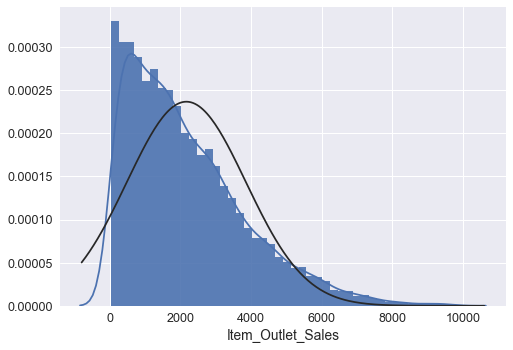

In [46]:
sns.distplot(Y['Item_Outlet_Sales'], hist_kws={'alpha': 0.9}, fit=norm)

We can see that Item_Outlet_Sales is skewed to the left.

In [47]:
Y.loc[:,'Item_Outlet_Sales'] = np.sqrt(Y.loc[:, 'Item_Outlet_Sales'])

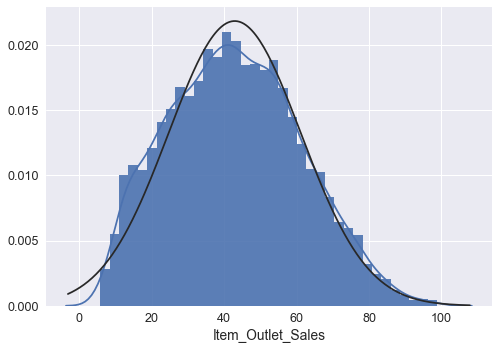

In [48]:
sns.distplot(Y['Item_Outlet_Sales'], hist_kws={'alpha': 0.9}, fit=norm)

In [49]:
skew(Y.loc[:, 'Item_Outlet_Sales'])

0.21033765781382077

## Encoding Nominal Features (Categorical, non-ordinal)

In [50]:
train_cat.columns

Index(['Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')

In [51]:
train_cat = pd.get_dummies(train_cat, columns=['Item_Type','Outlet_Location_Type','Outlet_Type'])

In [52]:
train_cat.columns

Index(['Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [53]:
## Reducing Dimensionality with PCA

In [54]:
# standardized_train_pca = standardized_train[['Item_Weight', 'Item_Visibility', 'Item_MRP',
#        'Item_Outlet_Sales', 'Item_Fat_Content_num', 'Outlet_Size_num',
#        'Outlet_Establishment_Year_num', 'Item_Type_Baking Goods',
#        'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
#        'Item_Type_Dairy', 'Item_Type_Frozen Foods',
#        'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
#        'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
#        'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
#        'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
#        'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
#        'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
#        'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
#        'Outlet_Type_Supermarket Type3']]

In [55]:
# pca = PCA()
# pca.fit(standardized_train_pca)
# np.cumsum(pca.explained_variance_ratio_)

In [56]:
# The idea is to start with n_components = number of columns. Then select the number of components that add up to 1 variance_ratio. Since cumsum reaches 1 at the 27th index, we can choose 27 to be our n_components number.

In [57]:
# pca = PCA(n_components=27)
# standardized_train_pca_array = pca.fit_transform(standardized_train_pca)

## Combining train_cat & train_num into X

In [58]:
train = pd.concat([train_num, train_cat], axis = 1)

In [59]:
train.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Item_MRP-2', 'Item_MRP-3',
       'Item_MRP-sq', 'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8515 entries, (FDA15, OUT049) to (DRG01, OUT046)
Data columns (total 32 columns):
Item_Weight                        8515 non-null float64
Item_Fat_Content                   8515 non-null float64
Item_Visibility                    8515 non-null float64
Item_MRP                           8515 non-null float64
Outlet_Establishment_Year          8515 non-null int64
Outlet_Size                        8515 non-null int64
Item_MRP-2                         8515 non-null float64
Item_MRP-3                         8515 non-null float64
Item_MRP-sq                        8515 non-null float64
Item_Type_Baking Goods             8515 non-null uint8
Item_Type_Breads                   8515 non-null uint8
Item_Type_Breakfast                8515 non-null uint8
Item_Type_Canned                   8515 non-null uint8
Item_Type_Dairy                    8515 non-null uint8
Item_Type_Frozen Foods             8515 non-null uint8
Item_Type_Fruits and Vegetabl

## Splitting into Training and Testing Data

In [61]:
X = train

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

In [62]:
print("X_train : " + str(type(X_train)) + str(X_train.shape))
print("X_test : " + str(type(X_test)) + str(X_test.shape))
print("y_train : " + str(type(Y_train)) + str(Y_train.shape))
print("y_test : " + str(type(Y_test)) + str(Y_test.shape))

X_train : <class 'pandas.core.frame.DataFrame'>(6812, 32)
X_test : <class 'pandas.core.frame.DataFrame'>(1703, 32)
y_train : <class 'pandas.core.frame.DataFrame'>(6812, 1)
y_test : <class 'pandas.core.frame.DataFrame'>(1703, 1)


In [63]:
# Standardize train data's numerical features

stdSc = StandardScaler()

X_train.loc[:,numerical_features] = stdSc.fit_transform(X_train.loc[:,numerical_features])
X_test.loc[:,numerical_features] = stdSc.fit_transform(X_test.loc[:,numerical_features])
# Y_train = stdSc.fit_transform(Y_train)
# Y_test = stdSc.fit_transform(Y_test)

# standardized_train = (standardized_train - standardized_train.mean())/standardized_train.std()

C:\Users\Seungjun\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Feature Selection

In [64]:
# model = LinearRegression()
# rfe = RFE(model, 10)
# fit = rfe.fit(X, Y)

# print(fit.n_features_)
# print(fit.support_)

## Making a Scoring Metric

In [65]:
# Define error measure for official scoring : RMSE

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring = scorer))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, Y_test, scoring = scorer))
    return(rmse)

## Linear Regression

In [66]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr_model).mean())
print("RMSE on Test set :", rmse_cv_test(lr_model).mean())

RMSE on Training set : 10.7115725867
RMSE on Test set : 10.6761600879


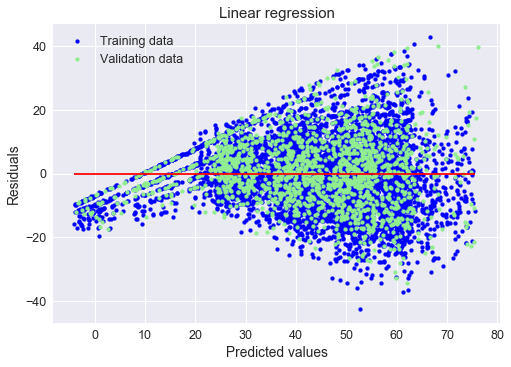

In [67]:
# Plot residuals
plt.scatter(lr_model.predict(X_train), lr_model.predict(X_train) - Y_train, c = "blue", label = "Training data", s=15)
plt.scatter(lr_model.predict(X_test), lr_model.predict(X_test) - Y_test, c = "lightgreen", label = "Validation data", s=15)

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(lr_model.predict(X_train)), xmax = max(lr_model.predict(X_train)), color = "red")

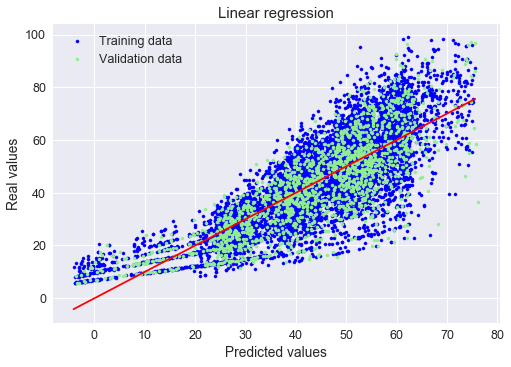

In [68]:
# Plot predictions
plt.scatter(lr_model.predict(X_train), Y_train, c = "blue", label = "Training data", s=10)
plt.scatter(lr_model.predict(X_test), Y_test, c = "lightgreen", label = "Validation data", s=10)

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")

plt.plot([min(lr_model.predict(X_train)), max(lr_model.predict(X_train))], 
         [min(lr_model.predict(X_train)), max(lr_model.predict(X_train))], c='red')

## Linear Regression with Polynomial Features

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly2_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly2_model.fit(X_train, Y_train)
    
# RMSE of Linear Regression model with 2nd degree polynomial features
print(np.sqrt(((poly2_model.predict(X_train) - Y_train) ** 2).mean()))
print(np.sqrt(((poly2_model.predict(X_test) - Y_test) ** 2).mean()))

Item_Outlet_Sales    10.205825
dtype: float64
Item_Outlet_Sales    3.665830e+11
dtype: float64


In [70]:
poly3_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly3_model.fit(X_train, Y_train)
    
# RMSE of Linear Regression model with 3nd degree polynomial features
print(np.sqrt(((poly3_model.predict(X_train) - Y_train) ** 2).mean()))
print(np.sqrt(((poly3_model.predict(X_test) - Y_test) ** 2).mean()))

Item_Outlet_Sales    9.609014
dtype: float64
Item_Outlet_Sales    2.460970e+12
dtype: float64


RMSE for test set increases dramatically than the linear regression model which just used linear features. So, we can assume that the data isn't really polynomial

## Ridge regularization (L2 penalty)

Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting. The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights. Ridge regression is an L2 penalized model where we simply add the squared sum of the weights to our cost function.

In [71]:
ridge = RidgeCV(alphas = [0.01, 0.05, 0.1, 0.3, 0.6, 1, 3, 5, 10, 30, 60, 100], cv=10)

ridge.fit(X_train, Y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

Best alpha : 5
Ridge RMSE on Training set : 10.7120886417
Ridge RMSE on Test set : 10.6193904221


In [72]:
ridge2 = make_pipeline(PolynomialFeatures(2), RidgeCV(alphas = [0.01, 0.05, 0.1, 0.3, 0.6, 1, 3, 5, 10, 30, 60, 100], cv=10))

ridge2.fit(X_train, Y_train)
    
# RMSE of Ridge Regression model with 2nd degree polynomial features
print(np.sqrt(((poly2_model.predict(X_train) - Y_train) ** 2).mean()))
print(np.sqrt(((poly2_model.predict(X_test) - Y_test) ** 2).mean()))

Item_Outlet_Sales    10.205825
dtype: float64
Item_Outlet_Sales    3.665830e+11
dtype: float64


## Lasso Regression

In [73]:
lasso = LassoCV(alphas = [1e-4, 5e-4, 1e-3, 5e-3, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, Y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha : 0.03


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso RMSE on Training set : 10.6912043501


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso RMSE on Test set : 10.569762983


## Elastic Net

In [74]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, Y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_

print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1
    
print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())

C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best l1_ratio : 1.0
Best alpha : 0.03


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed whe

ElasticNet RMSE on Training set : 10.6912043501


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You migh

ElasticNet RMSE on Test set : 10.569762983


## RandomForestRegressor

In [75]:
from sklearn.ensemble import RandomForestRegressor

C:\Users\Seungjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


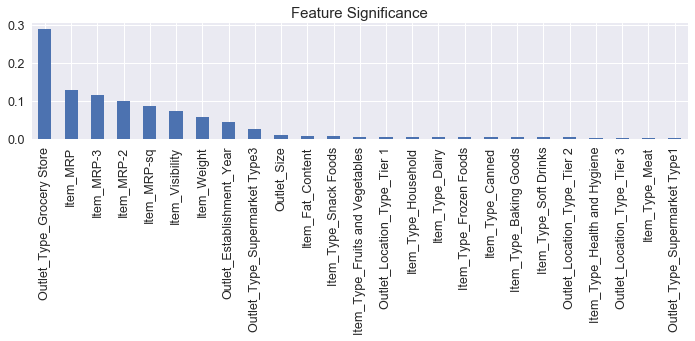

In [76]:
clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

# Fit model with training data
clf.fit(X_train, Y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [77]:
print("RandomForestRegressor RMSE on Training set :", rmse_cv_train(clf).mean())
print("RandomForestRegressor RMSE on Test set :", rmse_cv_test(clf).mean())

C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


RandomForestRegressor RMSE on Training set : 11.0549755274


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


RandomForestRegressor RMSE on Test set : 11.0564301278


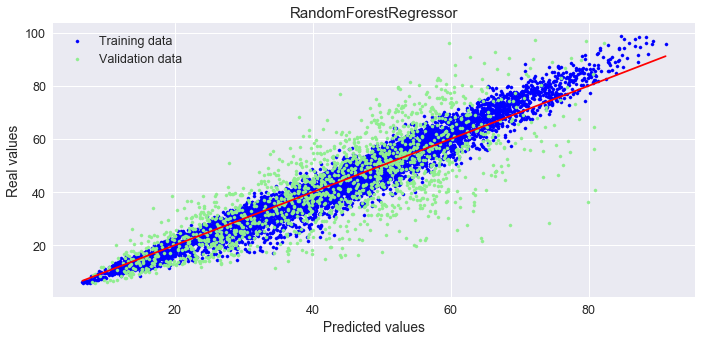

In [78]:
# Plot predictions

plt.figure(figsize=(10, 5))
plt.scatter(clf.predict(X_train), Y_train, c = "blue", label = "Training data", s=10)
plt.scatter(clf.predict(X_test), Y_test, c = "lightgreen", label = "Validation data", s=10)

plt.title("RandomForestRegressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")

plt.plot([min(clf.predict(X_train)), max(clf.predict(X_train))], 
         [min(clf.predict(X_train)), max(clf.predict(X_train))], c='red')
plt.tight_layout()

# Predicting Item_Outlet_Sales for Test Data

In [79]:
test = pd.read_csv('big mart test.csv')

In [80]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


## Filling in missing data in Test.csv

In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
Item_Identifier              5681 non-null object
Item_Weight                  4705 non-null float64
Item_Fat_Content             5681 non-null object
Item_Visibility              5681 non-null float64
Item_Type                    5681 non-null object
Item_MRP                     5681 non-null float64
Outlet_Identifier            5681 non-null object
Outlet_Establishment_Year    5681 non-null int64
Outlet_Size                  4075 non-null object
Outlet_Location_Type         5681 non-null object
Outlet_Type                  5681 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [82]:
test['Item_Weight']=\
test.groupby(['Item_Identifier'])['Item_Weight'].ffill().bfill()

In [83]:
test['Outlet_Size'] = test.groupby('Outlet_Identifier')['Outlet_Size'].ffill().bfill()

In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
Item_Identifier              5681 non-null object
Item_Weight                  5681 non-null float64
Item_Fat_Content             5681 non-null object
Item_Visibility              5681 non-null float64
Item_Type                    5681 non-null object
Item_MRP                     5681 non-null float64
Outlet_Identifier            5681 non-null object
Outlet_Establishment_Year    5681 non-null int64
Outlet_Size                  5678 non-null object
Outlet_Location_Type         5681 non-null object
Outlet_Type                  5681 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


## Fixing Weird Labels

In [85]:
# Since item_identifier is not a feature, we'll use that column as our index
test.set_index(['Item_Identifier', 'Outlet_Identifier'], inplace=True)

In [86]:
# Have inconsistent labels. Need to make it uniform.

test['Item_Fat_Content'].value_counts()

Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: Item_Fat_Content, dtype: int64

In [87]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].str.replace('LF', 'Low Fat')
test['Item_Fat_Content'] = test['Item_Fat_Content'].str.replace('reg', 'Regular')
test['Item_Fat_Content'] = test['Item_Fat_Content'].str.replace('low fat', 'Low Fat')

In [88]:
# 3 categories. No inconsistent labels. But unclear naming found. Let's change the label "high" to Big.
test['Outlet_Size'].value_counts()

Medium    2570
Small     2223
High       885
Name: Outlet_Size, dtype: int64

In [89]:
test['Outlet_Size'] = test['Outlet_Size'].str.replace('High', 'Big')

## Creating New Features

In [90]:
test['Item_MRP-2']= test['Item_MRP'] **2
test['Item_MRP-3']= test['Item_MRP'] **3
test['Item_MRP-sq'] = np.sqrt(test['Item_MRP'])

## Encoding Oridinal Features (Categorical)

In [91]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'Low Fat': 1, 'Regular':2})

In [92]:
test['Outlet_Size'] =\
test.Outlet_Size.replace({'Small': 1, 'Medium':2, 'Big':3})

## Fixing Skewedness and Standardizing Numerical Features 

In [93]:
# Differentiate numerical features (minus the target) and categorical features

test_categorical_features = test.select_dtypes(include = ["object"]).columns
test_numerical_features = test.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

test_num = test[test_numerical_features]
test_cat = test[test_categorical_features]

Numerical features : 9
Categorical features : 3


In [94]:
# Find nmerical features that have abs(skewness) of over 0.5
test_skewness = test_num.apply(lambda x: skew(x))

test_skewed = test_skewness.loc[(abs(test_skewness) > 0.5)]
test_skewed_features = test_skewed.index

In [95]:
test_skewed_features

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_MRP-2', 'Item_MRP-3'], dtype='object')

In [96]:
# sqrt transformation to fix skewedness

test_num[test_skewed_features] = np.sqrt(test_num[test_skewed_features])

C:\Users\Seungjun\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [97]:
# re-measuring skewness of skewed features : skewness of all features have been driven down below abs(0.5)
for feature in ['Item_Visibility', 'Item_MRP-2','Item_MRP-3']:
    print(skew(test_num[feature]))

-0.09491613782987758
0.13614557906208313
0.4905987578745139


## Encoding Nominal Features (Categorical, non-ordinal)

In [98]:
test_cat.columns

Index(['Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')

In [99]:
test_cat = pd.get_dummies(test_cat, columns=['Item_Type','Outlet_Location_Type','Outlet_Type'])

## Combining test_cat & test_num into X

In [100]:
test = pd.concat([test_num, test_cat], axis = 1)

## Filling in still remaining NaN

In [101]:
test['Outlet_Size'] = test['Outlet_Size'].fillna(test['Outlet_Size'].mean())

## Making "test_x" from test data

In [102]:
test_x = test

In [103]:
# standardizing numerical features of test dataset
test_x.loc[:,test_numerical_features] = stdSc.fit_transform(test_x.loc[:,test_numerical_features])

## Making the final prediction csv

In [104]:
test_x['Item_Outlet_Sales']=\
(elasticNet.predict(test_x))**2

In [105]:
test_x

,,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_MRP-2,Item_MRP-3,Item_MRP-sq,Item_Type_Baking Goods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
Item_Identifier,Outlet_Identifier,,,,,,,,,,,,,,,,,,,,,
FDW58,OUT049,1.723358,-0.740811,-1.370837,-0.536555,0.139891,3.360939e-01,-0.536555,-0.612599,-0.426798,0,...,0,0,1,0,0,0,1,0,0,1695.439134
FDW14,OUT017,-0.938719,1.349873,-0.347608,-0.868937,1.095512,3.360939e-01,-0.868937,-0.887836,-0.806828,0,...,0,0,0,1,0,0,1,0,0,1365.091041
NCN55,OUT010,0.408356,-0.740811,0.773872,1.629848,0.020438,3.360939e-01,1.629848,1.774362,1.457630,0,...,0,0,0,0,1,1,0,0,0,1057.552086
FDQ58,OUT017,-1.149333,-0.740811,-1.022980,0.226697,1.095512,3.360939e-01,0.226697,0.120266,0.327151,0,...,0,0,0,1,0,0,1,0,0,2388.319382
FDY38,OUT027,-0.617987,1.349873,1.044355,1.508110,-1.532446,3.360939e-01,1.508110,1.616868,1.368620,0,...,0,0,0,0,1,0,0,0,1,5174.589649
FDH56,OUT046,-0.617987,1.349873,0.183373,-0.386289,-0.099015,-1.090170e+00,-0.386289,-0.478945,-0.266972,0,...,0,0,1,0,0,0,1,0,0,1895.338352
FDL48,OUT018,1.424008,1.349873,0.509745,-1.471108,1.334417,3.360939e-01,-1.471108,-1.305140,-1.633975,1,...,0,0,0,0,1,0,0,1,0,658.925240
FDC48,OUT027,-1.365292,-0.740811,-1.008170,-0.970235,-1.532446,3.360939e-01,-0.970235,-0.965778,-0.931374,1,...,0,0,0,0,1,0,0,0,1,2326.525444
FDN33,OUT045,-1.365292,1.349873,1.108643,-0.732638,0.498248,-1.090170e+00,-0.732638,-0.778489,-0.646095,0,...,0,0,0,1,0,0,1,0,0,1536.276439


In [107]:
test_x['Item_Outlet_Sales'].mean()

2073.674685499953

In [108]:
final_test_df = test_x

In [109]:
final_test_df.reset_index(inplace=True)

In [110]:
final_test_df = final_test_df.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [112]:
final_test_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1695.439134
1,FDW14,OUT017,1365.091041
2,NCN55,OUT010,1057.552086
3,FDQ58,OUT017,2388.319382
4,FDY38,OUT027,5174.589649


## Saving the prediction csv to the current directory

In [114]:
final_test_df.to_csv('Seungjun-Kim-BigMartSales-Prediction.csv',sep=',',index=False)